In [1]:
import os, re
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from PIL import Image
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
# ROOT_PATH = '/content/drive/MyDrive/'
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
# TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
# VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TRAIN_PATH = '/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = '/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray/val/*/*'
TEST_PATH = '/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

# print(ROOT_PATH)

In [3]:
# import tensorflow as tf
# from tensorflow.keras.preprocessing import image_dataset_from_directory

# # 데이터셋 디렉토리 경로
# data_dir = '/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray/'

# # 데이터셋을 로드하고 전처리합니다.
# train_ds = image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2, # 검증 데이터셋을 위해 분리 비율을 설정합니다.
#     subset="training",
#     seed=123, # 재현성을 위한 시드값
#     image_size=(224, 224), # 이미지 크기를 설정합니다.
#     batch_size=32 # 배치 크기를 설정합니다.
# )

# val_ds = image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=123,
#     image_size=(224, 224),
#     batch_size=32
# )

# # 클래스의 이름을 확인합니다.
# class_names = train_ds.class_names
# print(class_names)

# # 데이터셋의 형태를 확인합니다.
# print(train_ds)

# # 데이터셋을 준비합니다.
# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5045
586
12


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4045
1012


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray/train/PNEUMONIA/person863_virus_1508.jpeg
Pneumonia image path
/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray/train/PNEUMONIA/person392_virus_782.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1031
Pneumonia images count in training set: 3014


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
from pathlib import Path
import imghdr

data_dir = "/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray"
image_extensions = [".png", ".jpeg", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [10]:
# from pathlib import Path
# import filetype


# # RFC image file extensions supported by TensorFlow
# img_exts = {"png", "jepg","jpg", "gif", "bmp"}

# path = Path("/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray")

# for file in path.iterdir():
#     if file.is_dir():
#         continue

#     ext = filetype.guess_extension(file)

#     if ext is None:
#         print(f"'{file}': extension cannot be guessed from content")
#     elif ext not in img_exts:
#         print(f"'{file}': not a supported image file")

## 데이터 Augumentation 적용(좌우반전)

In [11]:
# #2-1 좌우 반전
# def augment(image,label):
#     image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
#     return image,label

# def prepare_for_training(ds, shuffle_buffer_size=1000):
#     # augment 적용 부분이 배치처리 함수에 추가되었습니다.
#     ds = ds.map(
#             augment,       # augment 함수 적용
#             num_parallel_calls=2
#         )
#     ds = ds.shuffle(buffer_size=shuffle_buffer_size)
#     ds = ds.repeat()
#     ds = ds.batch(BATCH_SIZE)
#     ds = ds.prefetch(buffer_size=AUTOTUNE)

#     return ds

# train_ds = prepare_for_training(train_ds)
# val_ds = prepare_for_training(val_ds)

In [12]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4045
Validating images count: 1012


In [13]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [14]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


2023-11-09 15:09:33.187965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4045]
	 [[{{node Placeholder/_0}}]]
2023-11-09 15:09:33.195724: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [17]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

586


In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

##3. 데이터 시각화

In [19]:
from pathlib import Path
import imghdr

data_dir = "/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray"
image_extensions = [".png", ".jpeg", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")

In [20]:
# from pathlib import Path
# import imghdr

# from pathlib import Path
# import imghdr

# img_link=list(Path("/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray").glob(r'**/*.jpeg'))

# count_num=0
# for lnk in img_link:
#     binary_img=open(lnk,'rb')
#     find_img=tf.compat.as_bytes('JFIF') in binary_img.peek(10)#The JFIF is a JPEG File Interchange Format (JFIF). It is a standard which we gauge if an image is corrupt or substandard
#     if not find_img:
#         count_num+=1
#         os.remove(str(lnk))
# print('Total %d pcs image delete from Dataset' % count_num)

2023-11-09 15:09:33.418210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4045]
	 [[{{node Placeholder/_0}}]]
2023-11-09 15:09:33.418361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4045]
	 [[{{node Placeholder/_0}}]]


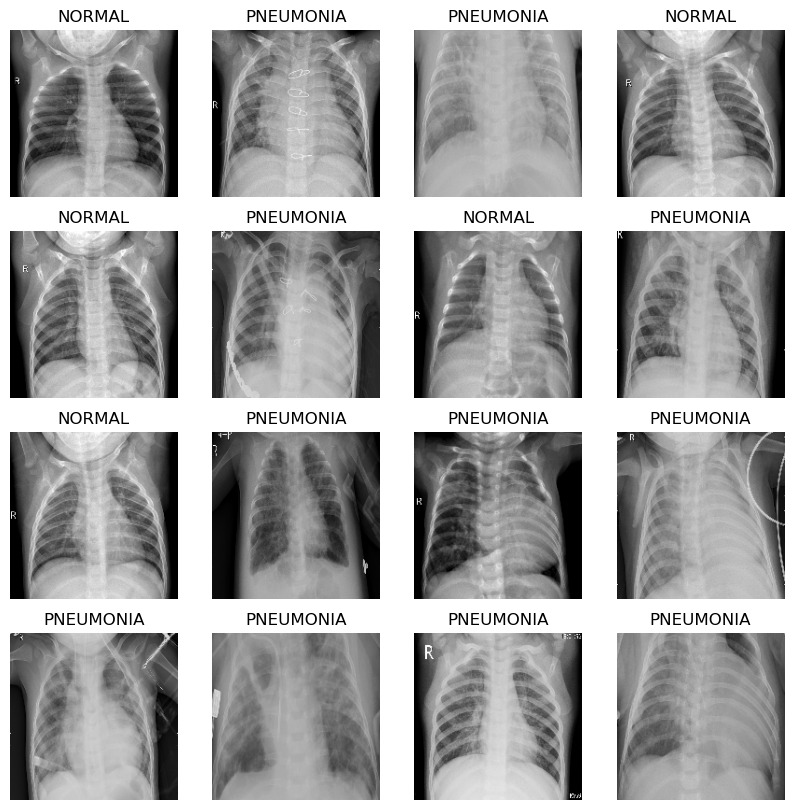

In [21]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## 4. CNN 모델링

In [22]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [23]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [24]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## 5. 데이터 imbalance 처리

In [25]:
from PIL import Image
import os

# 이미지 디렉토리 설정
image_dir = '/Users/inho/study/github/AIFFEL_quest_iNho/main_quest/chest_xray'

# 이미지 디렉토리의 모든 파일에 대해
for filename in os.listdir(image_dir):
    if filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".gif") or filename.endswith(".bmp"):
        try:
            # 이미지 파일 열기
            img = Image.open(os.path.join(image_dir, filename)) 
            # 이미지 파일 로드
            img.verify() 
        except (IOError, SyntaxError) as e:
            print(f'File {filename} is corrupted. Deleting...')
            # 손상된 이미지 파일 삭제
            os.remove(os.path.join(image_dir, filename))
    else:
        print(f'File {filename} is not an image file')

File test is not an image file
File train is not an image file
File val is not an image file


In [26]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [27]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [28]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10


2023-11-09 15:09:36.690982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype double and shape [2]
	 [[{{node Placeholder/_16}}]]
2023-11-09 15:09:36.691155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_16' with dtype double and shape [2]
	 [[{{node Placeholder/_16}}]]


145/252 [================>.............] - ETA: 14s - loss: 0.5221 - accuracy: 0.7388 - precision: 0.9305 - recall: 0.7056

2023-11-09 15:09:58.956070: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]


159/252 [=================>............] - ETA: 12s - loss: 0.5054 - accuracy: 0.7488 - precision: 0.9351 - recall: 0.7155

2023-11-09 15:10:01.053336: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]]


InvalidArgumentError: Graph execution error:

Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_4785]

## 7. 결과 확인

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
model = keras.models.Model(inputs=input, outputs=residual_out)
model.summary()

## 4. ResNet-18

In [ ]:
# Resnet-18 추가
def conv_block(x, filters, kernel_size, strides=1):
    x_shortcut = x

    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Identity(skip) connection
    if strides != 1:
        x_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='valid')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=128, kernel_size=3, strides=2)
    x = conv_block(x, filters=128, kernel_size=3)
    x = conv_block(x, filters=256, kernel_size=3, strides=2)
    x = conv_block(x, filters=256, kernel_size=3)
    x = conv_block(x, filters=512, kernel_size=3, strides=2)
    x = conv_block(x, filters=512, kernel_size=3)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

## 5. 데이터 imbalance 처리

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


## 6. 모델 훈련

In [ ]:
IMAGE_SIZE = 180
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

NameError: name 'initial_learning_rate' is not defined

In [ ]:
# IMAGE_SIZE = 180
# initial_learning_rate = 0.001  # 이 값을 적절한 학습률로 설정하세요
# optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

## 7. 결과 확인

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

plot_model(model, show_shapes=True, to_file='residual_module.png')

In [ ]:
#nput layer와 residual module을 연결해서 모델을 만듭니다.
model = keras.models.Model(inputs=input, outputs=residual_out)
model.summary()

# plot_model 함수로 모델의 구조를 시각화합니다.
plot_model(model, show_shapes=True, to_file='residual_module.png')

In [ ]:
# Resnet-18 추가
def conv_block(x, filters, kernel_size, strides=1):
    x_shortcut = x

    x = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Identity(skip) connection
    if strides != 1:
        x_shortcut = Conv2D(filters, kernel_size=(1, 1), strides=strides, padding='valid')(x_shortcut)
        x_shortcut = BatchNormalization()(x_shortcut)

    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)

    return x

def resnet18(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=64, kernel_size=3)
    x = conv_block(x, filters=128, kernel_size=3, strides=2)
    x = conv_block(x, filters=128, kernel_size=3)
    x = conv_block(x, filters=256, kernel_size=3, strides=2)
    x = conv_block(x, filters=256, kernel_size=3)
    x = conv_block(x, filters=512, kernel_size=3, strides=2)
    x = conv_block(x, filters=512, kernel_size=3)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10 
# 초기 학습률 설정
initial_learning_rate = 0.0001

IMAGE_SIZE = 180
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=METRICS
    )

